### Denoising Autoencoders And Where To Find Them (10 pts)

Today we're going to train deep autoencoders and deploy them to faces and search for similar images.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

In [18]:
!pip3 install scikit-learn --no-cache

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.7 MB 13.1 MB/s 
     |████████████████████████████████| 33.8 MB 6.3 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.1.0
    Uninstalling scipy-1.1.0:
      Successfully uninstalled scipy-1.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.10 requires pillow>6.0.0, but you have pillow 5.1.0 which is incompatible.


In [1]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall20/week08_generative/lfw_dataset.py -O lfw_dataset.py
!pip install Image Pillow==5.1.0 scipy==1.1.0

import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

LATENT_DIMENSION = 4


device = torch.device("cpu") # or you print here you favorite gpu card
#torch.set_default_tensor_type(torch.cuda.FloatTensor) 
# uses cuda floats by default
print(device)

--2022-12-14 03:20:49--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall20/week08_generative/lfw_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3056 (3.0K) [text/plain]
Saving to: ‘lfw_dataset.py’

lfw_dataset.py      100%[===================>]   2.98K  --.-KB/s    in 0s      

2022-12-14 03:20:49 (56.9 MB/s) - ‘lfw_dataset.py’ saved [3056/3056]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cpu


In [3]:
BATCH_SIZE = 32

In [4]:
import numpy as np
from lfw_dataset import fetch_lfw_dataset
from sklearn.model_selection import train_test_split
X, attr = fetch_lfw_dataset(use_raw=True, dimx=38, dimy=38)
X = X.transpose([0, 3, 1, 2]).astype('float32') / 256.0

img_shape = X.shape[1:]

X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [5]:
X_train_tensor = torch.from_numpy(X_train).type(torch.DoubleTensor)
X_test_tensor = torch.Tensor(X_test).type(torch.DoubleTensor)

X shape: (13143, 3, 38, 38)
attr shape: (13143, 73)


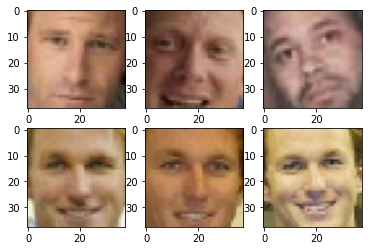

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i].transpose([1,2,0]))

print("X shape:",X.shape)
print("attr shape:",attr.shape)

### Autoencoder architecture

Let's design autoencoder as a single lasagne network, going from input image through bottleneck into the reconstructed image.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [7]:
class Reshape(nn.Module):
    """ this class corresponds to torch.reshape function and may be used as a reshape layer """
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
    def forward(self, input):
        reshaped = input.reshape(*self.shape)
        return reshaped

In [6]:
class PCAAutoencoder(nn.Module):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    def __init__(self, code_size=50):
        super(PCAAutoencoder, self).__init__()
        self.enc = nn.Sequential(Reshape(-1, np.prod(img_shape)), nn.Linear(np.prod(img_shape), code_size))
        self.dec = nn.Sequential(nn.Linear(code_size, np.prod(img_shape)), Reshape(-1, img_shape[0], img_shape[1], img_shape[2])) 
    
    def batch_loss(self, batch, reference):
        encoded = self.enc(batch)
        reconstruction = self.dec(encoded)
        return torch.mean((reference - reconstruction) ** 2)
    

### Train the model

As usual, iterate minibatches of data and call train_step, then evaluate loss on validation data.

__Note to py2 users:__ you can safely drop `flush=True` from any code below.

In [8]:
device = torch.device('cuda')

In [9]:
img_shape

(3, 38, 38)

In [10]:
from tqdm import tqdm
def train(model, dataset, dataset_test, num_epoch=32, gd=None, noise_function=None, noise_function_params=None):
    model.double()
    model.to(device)
    model.to(device)
    if gd is None:
        gd = optim.Adamax(model.parameters(), lr=0.002)
    if noise_function_params is None:
        noise_function_params = {}
    
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)
    scores = []

    for epoch in range(num_epoch):
        model.train(True)
        for i, (batch) in tqdm(enumerate(dataloader)):
            gd.zero_grad()
            if noise_function is not None:
                batch_noised = noise_function(batch, **noise_function_params).to(device=device)
                loss = model.batch_loss(batch_noised, batch.to(device=device))
            else:
                batch = batch.to(device=device)
                loss = model.batch_loss(batch, batch)
            (loss).backward()
            losses.append(loss.data.cpu().numpy())
            gd.step()
            gd.zero_grad()
        train_mse = np.mean(losses[-(i+1):])
        
        model.train(False)
        for i, (batch) in enumerate(dataloader_test):
            batch = batch.to(device=device)
            scores.append(model.batch_loss(batch, batch).data.cpu().numpy())
        test_mse  = np.mean(scores[-(i+1):])

        print(f"{epoch+1}, Train loss: {train_mse}, Test loss: {test_mse}")

In [11]:
def visualize(img, model):
    """Draws original, encoded and decoded images"""
    model.train(False)
    code = model.enc(img[None].cuda(device=device))

    reco = model.dec(code)

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img.cpu().numpy().transpose([1, 2, 0]).clip(0, 1))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.cpu().detach().numpy().reshape([code.shape[-1] // 2, -1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco[0].cpu().detach().numpy().transpose([1, 2, 0]).clip(0, 1))
    plt.show()


In [ ]:
aenc = PCAAutoencoder()
train(aenc, X_train_tensor, X_test_tensor, 40)

370it [00:01, 341.88it/s]


1, Train loss: 0.10498879991460483, Test loss: 0.023718459145767805


370it [00:00, 390.00it/s]


2, Train loss: 0.023224929351532756, Test loss: 0.02311669320398521


370it [00:00, 386.08it/s]


3, Train loss: 0.02289064397643855, Test loss: 0.02288638077242359


370it [00:00, 385.71it/s]


4, Train loss: 0.022625651362880264, Test loss: 0.02243729302604698


370it [00:00, 388.71it/s]


5, Train loss: 0.022170750716946006, Test loss: 0.022150270168408696


370it [00:00, 385.15it/s]


6, Train loss: 0.0208768131223575, Test loss: 0.020158319606787916


370it [00:00, 387.97it/s]


7, Train loss: 0.019139289153930532, Test loss: 0.01859768933379953


370it [00:00, 381.36it/s]


8, Train loss: 0.018007354158483667, Test loss: 0.017803908442163677


370it [00:00, 390.56it/s]


9, Train loss: 0.01694775093999616, Test loss: 0.01664803359037861


370it [00:00, 387.12it/s]


10, Train loss: 0.016048616688253907, Test loss: 0.016147694122072627


370it [00:00, 385.48it/s]


11, Train loss: 0.014799289240631069, Test loss: 0.016007669509296177


370it [00:00, 387.62it/s]


12, Train loss: 0.013646075836352013, Test loss: 0.013752547958140605


370it [00:01, 205.43it/s]


13, Train loss: 0.012633772292364029, Test loss: 0.011989275749311174


370it [00:01, 245.28it/s]


14, Train loss: 0.011675936184947042, Test loss: 0.011574880884238461


370it [00:00, 383.57it/s]


15, Train loss: 0.010894794484457427, Test loss: 0.011645455537119995


370it [00:00, 392.47it/s]


16, Train loss: 0.010175310034082665, Test loss: 0.009840974856569583


370it [00:00, 387.79it/s]


17, Train loss: 0.009654159026038493, Test loss: 0.009450307076593941


370it [00:00, 384.54it/s]


18, Train loss: 0.00914232778407322, Test loss: 0.009627454369268637


370it [00:00, 385.62it/s]


19, Train loss: 0.008780165876199104, Test loss: 0.009056104601338513


370it [00:00, 388.45it/s]


20, Train loss: 0.00852583088061953, Test loss: 0.008736398093278886


370it [00:00, 387.28it/s]


21, Train loss: 0.008073534157311348, Test loss: 0.00805631062586303


370it [00:00, 386.64it/s]


22, Train loss: 0.0079147388209048, Test loss: 0.00782873576737048


370it [00:00, 385.89it/s]


23, Train loss: 0.007661317301591133, Test loss: 0.008207638104865914


370it [00:00, 387.91it/s]


24, Train loss: 0.007365313632507611, Test loss: 0.0073266653318182235


370it [00:00, 384.84it/s]


25, Train loss: 0.007203223816869241, Test loss: 0.007121396779075485


370it [00:00, 384.50it/s]


26, Train loss: 0.007009428015925705, Test loss: 0.006826364613344975


370it [00:00, 386.85it/s]


27, Train loss: 0.006761572016086535, Test loss: 0.006919323073844764


370it [00:00, 386.90it/s]


28, Train loss: 0.006727406201146879, Test loss: 0.006646708603146247


370it [00:00, 388.37it/s]


29, Train loss: 0.006602987348659294, Test loss: 0.0069500479340628375


370it [00:00, 382.17it/s]


30, Train loss: 0.006501745000193748, Test loss: 0.006359668140909515


370it [00:00, 383.45it/s]


31, Train loss: 0.006358400230534713, Test loss: 0.006423968487299561


370it [00:00, 389.13it/s]


32, Train loss: 0.006357215502667777, Test loss: 0.006243305032256343


370it [00:00, 387.24it/s]


33, Train loss: 0.0062415415040129475, Test loss: 0.006174490291851605


370it [00:00, 389.85it/s]


34, Train loss: 0.0061585721751831754, Test loss: 0.006181103235864329


370it [00:00, 393.64it/s]


35, Train loss: 0.0060965128750084426, Test loss: 0.006243373282081065


370it [00:00, 388.83it/s]


36, Train loss: 0.00602925681921164, Test loss: 0.006007895183081578


370it [00:00, 386.72it/s]


37, Train loss: 0.006014386776160402, Test loss: 0.006091740676661374


370it [00:00, 394.51it/s]


38, Train loss: 0.00595579914362877, Test loss: 0.005945132075320902


370it [00:00, 389.44it/s]


39, Train loss: 0.00592864959482024, Test loss: 0.006102200040911266


370it [00:00, 387.38it/s]


40, Train loss: 0.005863902608254632, Test loss: 0.005994040063153518


In [47]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch = batch.to(device=device)
    scores.append(aenc.batch_loss(batch, batch).data.cpu().numpy())
print (np.mean(scores))

NameError: ignored

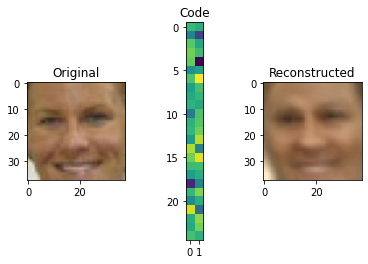

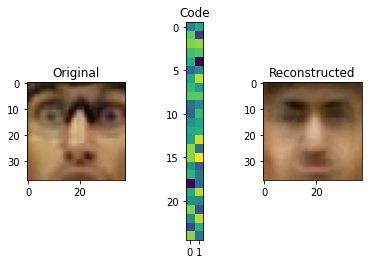

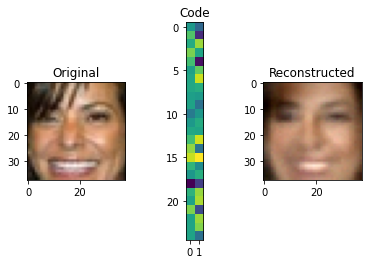

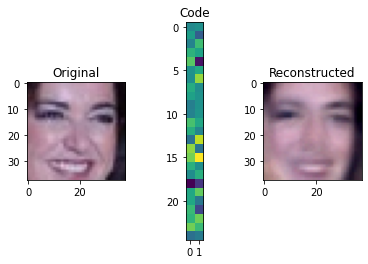

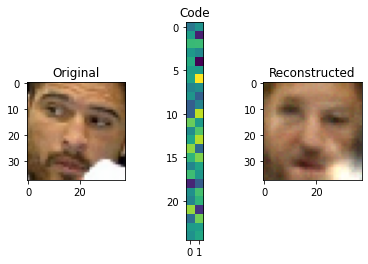

In [ ]:
for i in range(5):
    img = X_test_tensor[i]
    visualize(img, aenc)


### Going deeper

PCA is neat but surely we can do better. This time we want you to build a deep autoencoder by... stacking more layers.

In particular, your encoder and decoder should be at least 3 layers deep each. You can use any nonlinearity you want and any number of hidden units in non-bottleneck layers provided you can actually afford training it.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are allowed but not required. To undo convolution use L.Deconv2D, pooling - L.UpSampling2D.
* Adding activation after bottleneck is allowed, but not strictly necessary.

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample = False, use_bn = True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4 if downsample else 3, padding=1, stride=2 if downsample else 1)
        self.bn = nn.BatchNorm2d(out_channels) if use_bn else nn.Identity()
        self.act = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))


class UpConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_bn = True):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels) if use_bn else nn.Identity()
        self.act = nn.ReLU(0.1)

    def forward(self, x):
        return self.act(self.bn(self.conv(self.up(x))))


class Interpolate(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.interp = nn.functional.interpolate
        self.size = size
        
    def forward(self, x):
        x = self.interp(x, size=self.size)
        return x



class Encoder(nn.Module):
    def __init__(self, code_size, use_bn = True):
        super().__init__()
        self.enc = nn.Sequential(*[
            ConvBlock(3, 8, True, use_bn),  # 19
            ConvBlock(8, 16, False, use_bn),
            ConvBlock(16, 32, True, use_bn),  # 9
            ConvBlock(32, 64, False, use_bn),
            ConvBlock(64, 128, True, use_bn), # 4
            Reshape(-1, 2048),
            nn.Linear(2048, 512),
            nn.LeakyReLU(0.1),
            nn.Linear(512, code_size),
        ])

    def forward(self, x):
        return self.enc(x)


class Decoder(nn.Module):
    def __init__(self, code_size, use_bn = True):
        super().__init__()
        self.dec = nn.Sequential(*[
            nn.Linear(code_size, 512),
            nn.ReLU(),
            nn.Linear(512, 2048),
            nn.ReLU(),
            Reshape(-1, 2048, 1, 1),
            UpConvBlock(2048, 1024, use_bn),  # 2
            ConvBlock(1024, 512, False, use_bn),
            UpConvBlock(512, 256, use_bn), # 4
            ConvBlock(256, 128, False, use_bn),
            UpConvBlock(128, 64, use_bn), # 8
            ConvBlock(64, 32, False, use_bn),
            UpConvBlock(32, 16, use_bn),  # 8
            ConvBlock(16, 8, False, use_bn),
            UpConvBlock(8, 4, use_bn), # 16
            ConvBlock(4, 4, False, use_bn),
            UpConvBlock(4, img_shape[0], use_bn), # 32
            Interpolate((img_shape[1], img_shape[2])),
            nn.Conv2d(img_shape[0], img_shape[0], kernel_size=1),
            nn.Sigmoid(),
        ])

    def forward(self, x):
        return self.dec(x)



class ConvDeepAutoencoder(nn.Module):
    def __init__(self, code_size=50):
        super().__init__()
        self.enc = Encoder(code_size, True)
        self.dec = Decoder(code_size)
    
    def batch_loss(self, batch, reference):
        a = self.enc(batch)
        reconstruction = self.dec(a)
        return torch.mean((reference - reconstruction)**2)


class DeepAutoencoder(nn.Module):
    def __init__(self, code_size=50):
        super(DeepAutoencoder, self).__init__()
        self.enc = nn.Sequential(*[
            Reshape(-1, np.prod(img_shape)),
            nn.Linear(np.prod(img_shape), code_size * 16),
            nn.LeakyReLU(0.1),
            nn.Linear(code_size * 16, code_size * 4),
            # nn.LeakyReLU(0.1),
            # nn.Linear(code_size * 16, code_size * 8),
            # nn.LeakyReLU(0.1),
            # nn.Linear(code_size * 8, code_size * 4),
            # nn.LeakyReLU(0.1),
            # nn.Linear(code_size * 4, code_size * 2),
            # nn.LeakyReLU(0.1),
            # nn.Sigmoid(),
            nn.LeakyReLU(0.1),
            nn.Linear(code_size * 4, code_size),
        ])
        self.dec = nn.Sequential(*[
            nn.Linear(code_size, code_size * 16),
            nn.LeakyReLU(0.1),
            nn.Linear(code_size * 16, code_size * 4),
            nn.LeakyReLU(0.1),
            # nn.Linear(code_size * 2, code_size * 4),
            # nn.ReLU(),
            # nn.Linear(code_size * 4, code_size * 8),
            # nn.ReLU(),
            # nn.Linear(code_size * 8, code_size * 16),
            # nn.ReLU(),
            nn.Linear(code_size * 4, np.prod(img_shape)),
            Reshape(-1, img_shape[0], img_shape[1], img_shape[2]),
            nn.Sigmoid()
        ])
    
    def batch_loss(self, batch, reference):
        a = self.enc(batch)
        reconstruction = self.dec(a)
        return torch.mean((reference - reconstruction)**2)

In [54]:
#Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512,1024]:
    help_tensor = next(iter(DataLoader(X_train_tensor, batch_size=BATCH_SIZE)))
    model = DeepAutoencoder(code_size).double().to(device)
    encoder_out = model.enc(help_tensor.cuda(device))
    decoder_out = model.dec(encoder_out)
    print("Testing code size %i" % code_size)

    assert encoder_out.shape[1:] == torch.Size([code_size]),"encoder must output a code of required size"
    assert decoder_out.shape[1:] == img_shape,   "decoder must output an image of valid shape"

    assert (sum([1 + len(list(c1level.children())) for c1level in model.dec.children()]) >= 6),  "decoder must contain at least 3 dense layers"

    del encoder_out
    del decoder_out
    torch.cuda.empty_cache()
print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
Testing code size 1024
All tests passed!


__Hint:__ if you're getting "Encoder layer is smaller than bottleneck" error, use code_size when defining intermediate layers. 

For example, such layer may have code_size*2 units.

In [58]:
aenc_deep = DeepAutoencoder()
conv_aenc = ConvDeepAutoencoder()


In [29]:
optimizer = optim.Adam(aenc_deep.parameters(), lr=0.00005)

In [62]:
train(aenc_deep, X_train_tensor, X_test_tensor, num_epoch=300) # after 300 epochs

370it [00:04, 82.54it/s]


1, Train loss: 0.0055689665676895775, Test loss: 0.005419146502489122


370it [00:04, 84.88it/s]


2, Train loss: 0.00449297831063322, Test loss: 0.005413085608426021


370it [00:04, 84.88it/s]


3, Train loss: 0.004442708920020409, Test loss: 0.005414603316675219


161it [00:01, 84.37it/s]


KeyboardInterrupt: ignored

Training may take long, it's okay.

Final MSE: 0.005386624554645278


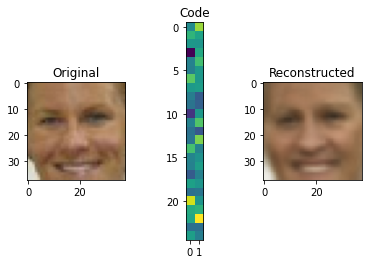

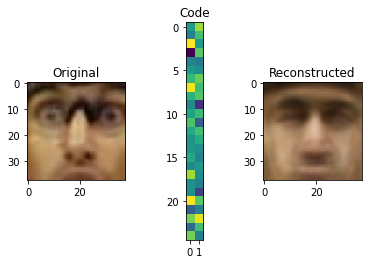

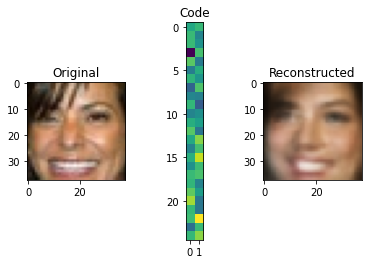

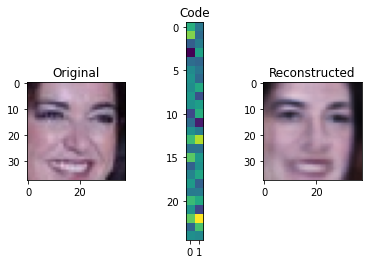

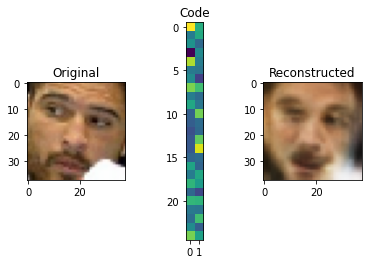

In [63]:
aenc_deep.train(False)
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch = batch.to(device=device)
    scores.append(aenc_deep.batch_loss(batch, batch).data.cpu().numpy())
    encoder_out = aenc_deep.enc(batch)
reconstruction_mse  = np.mean(scores)

assert reconstruction_mse <= 0.0055, "Compression is too lossy. See tips below."
assert len(encoder_out.shape) == 2 and encoder_out.shape[1] == 50, "Make sure encoder has code_size units"
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test_tensor[i]
    visualize(img,aenc_deep)

__Tips:__ If you keep getting "Compression to lossy" error, there's a few things you might try:

* Make sure it converged. Some architectures need way more than 32 epochs to converge. They may fluctuate a lot, but eventually they're going to get good enough to pass. You may train your network for as long as you want.

* Complexity. If you already have, like, 152 layers and still not passing threshold, you may wish to start from something simpler instead and go in small incremental steps.

* Architecture. You can use any combination of layers (including convolutions, normalization, etc) as long as __encoder output only stores 50 numbers per training object__. 

A cunning learner can circumvent this last limitation by using some manual encoding strategy, but he is strongly recommended to avoid that.

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.

In [13]:
def apply_gaussian_noise(X, sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    
    noise = torch.normal(mean=0., std=sigma, size=X.shape)
        
    return X + noise
    

In [67]:
#noise tests
theoretical_std = (X[:100].std() ** 2 + 0.5 ** 2)**.5
our_std = apply_gaussian_noise(torch.from_numpy(X[:100]), sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(torch.from_numpy(X[:100]), sigma=0.5).mean() - torch.from_numpy(X[:100]).mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

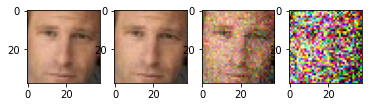

In [68]:
plt.subplot(1,4,1)
plt.imshow(X[0].transpose([1,2,0]))
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.01).data.numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.1).data.numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.5).data.numpy()[0].transpose([1,2,0]).clip(0, 1))

In [71]:
aenc = DeepAutoencoder()
train(aenc, X_train_tensor, X_test_tensor, 50, noise_function=apply_gaussian_noise)

370it [00:06, 59.66it/s]


1, Train loss: 0.020347442750826575, Test loss: 0.01445864003033905


370it [00:04, 82.38it/s]


2, Train loss: 0.01336930407616438, Test loss: 0.01292364743775858


370it [00:04, 82.05it/s]


3, Train loss: 0.012136363934485658, Test loss: 0.011393277543115646


370it [00:04, 80.22it/s]


4, Train loss: 0.010940329278867136, Test loss: 0.010960891642824796


370it [00:04, 82.12it/s]


5, Train loss: 0.010281441075798044, Test loss: 0.01013399841268609


370it [00:04, 81.66it/s]


6, Train loss: 0.009670046775399769, Test loss: 0.009513340475460276


370it [00:04, 81.92it/s]


7, Train loss: 0.009296198725135466, Test loss: 0.009305126404213635


370it [00:04, 81.67it/s]


8, Train loss: 0.008895744721073818, Test loss: 0.008795644702098872


370it [00:04, 74.29it/s]


9, Train loss: 0.008522815813413867, Test loss: 0.008412591752032789


370it [00:04, 81.56it/s]


10, Train loss: 0.008235007745518136, Test loss: 0.008222467695906677


370it [00:04, 77.47it/s]


11, Train loss: 0.007997758830590063, Test loss: 0.008073632384235275


370it [00:04, 81.44it/s]


12, Train loss: 0.007753185789574397, Test loss: 0.007742889499964003


370it [00:04, 81.56it/s]


13, Train loss: 0.007538551754534794, Test loss: 0.007822204533301633


370it [00:04, 81.70it/s]


14, Train loss: 0.00736912468962324, Test loss: 0.007492288466239762


370it [00:04, 81.80it/s]


15, Train loss: 0.007237907983601437, Test loss: 0.0073124173776442265


370it [00:04, 81.51it/s]


16, Train loss: 0.0070451620978559375, Test loss: 0.007219366044057066


370it [00:04, 81.88it/s]


17, Train loss: 0.00691358234373465, Test loss: 0.006952721459705215


370it [00:04, 81.69it/s]


18, Train loss: 0.00677248808365956, Test loss: 0.006938175595294249


370it [00:04, 81.29it/s]


19, Train loss: 0.006666859814907405, Test loss: 0.006959713513059684


370it [00:04, 81.56it/s]


20, Train loss: 0.006548310482996775, Test loss: 0.006772018390643056


370it [00:04, 81.36it/s]


21, Train loss: 0.006466157904426009, Test loss: 0.006632661825113205


370it [00:04, 81.20it/s]


22, Train loss: 0.006351728928433724, Test loss: 0.006470471636624243


370it [00:04, 81.22it/s]


23, Train loss: 0.006257787694391507, Test loss: 0.006486426769664271


370it [00:04, 80.95it/s]


24, Train loss: 0.006160968317595448, Test loss: 0.006454434485141186


370it [00:04, 81.30it/s]


25, Train loss: 0.006114349766973408, Test loss: 0.006227066609621625


370it [00:04, 81.39it/s]


26, Train loss: 0.006025575866071089, Test loss: 0.006441498019764162


370it [00:04, 81.04it/s]


27, Train loss: 0.005990288165961352, Test loss: 0.006191793790039721


370it [00:04, 80.59it/s]


28, Train loss: 0.005926327068905071, Test loss: 0.00635962095849366


370it [00:04, 80.88it/s]


29, Train loss: 0.005876071942498584, Test loss: 0.006178042327489025


370it [00:04, 80.84it/s]


30, Train loss: 0.005827238111815597, Test loss: 0.005980273983064365


370it [00:04, 81.28it/s]


31, Train loss: 0.0057851162590063475, Test loss: 0.006106001327437804


370it [00:04, 81.09it/s]


32, Train loss: 0.005750155973602938, Test loss: 0.006027388594065622


370it [00:04, 80.73it/s]


33, Train loss: 0.005697540229770096, Test loss: 0.00593336377158038


370it [00:04, 80.64it/s]


34, Train loss: 0.005667338759417676, Test loss: 0.005998025753437456


370it [00:04, 80.50it/s]


35, Train loss: 0.005619356666737687, Test loss: 0.006166411594674273


370it [00:04, 80.11it/s]


36, Train loss: 0.005566087503820216, Test loss: 0.006099497822806753


370it [00:04, 79.66it/s]


37, Train loss: 0.005533358663980959, Test loss: 0.005842746623658811


370it [00:04, 79.52it/s]


38, Train loss: 0.0054992780514369136, Test loss: 0.0058523283656379144


370it [00:04, 79.94it/s]


39, Train loss: 0.005462906975344788, Test loss: 0.0057433112846321886


370it [00:04, 79.83it/s]


40, Train loss: 0.005436297499924867, Test loss: 0.006167568751777266


370it [00:04, 80.21it/s]


41, Train loss: 0.005402303617898829, Test loss: 0.005840250263330288


370it [00:04, 79.86it/s]


42, Train loss: 0.005378253134716222, Test loss: 0.0059006639708956855


370it [00:04, 74.15it/s]


43, Train loss: 0.005348595227770352, Test loss: 0.005754979739461876


370it [00:04, 80.25it/s]


44, Train loss: 0.0053284394727052525, Test loss: 0.005780584756125123


370it [00:04, 80.54it/s]


45, Train loss: 0.005278772158693105, Test loss: 0.005601872297871535


370it [00:04, 80.08it/s]


46, Train loss: 0.00527628967201267, Test loss: 0.005692278337031421


370it [00:04, 80.00it/s]


47, Train loss: 0.005262262929497793, Test loss: 0.005703315322551712


370it [00:04, 80.06it/s]


48, Train loss: 0.005236341998820499, Test loss: 0.005654010382799353


370it [00:04, 78.09it/s]


49, Train loss: 0.005209076892087417, Test loss: 0.005518166266925722


370it [00:04, 78.28it/s]


50, Train loss: 0.005193468154422515, Test loss: 0.005621123423215077


__Note:__ if it hasn't yet converged, increase the number of iterations.

__Bonus:__ replace gaussian noise with masking random rectangles on image.

Final MSE: 0.005691493126689841


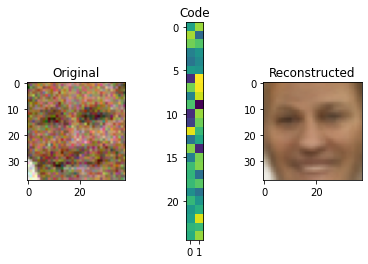

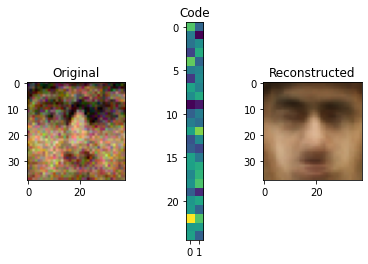

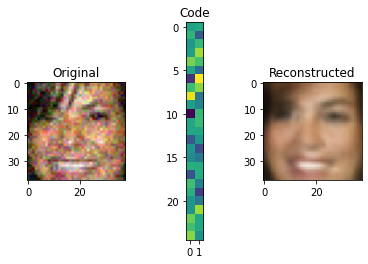

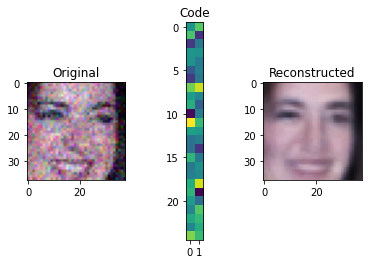

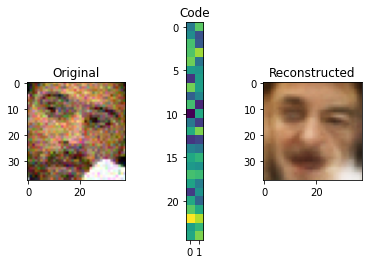

In [72]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch_noised = apply_gaussian_noise(batch).to(device=device)
    scores.append(aenc.batch_loss(batch_noised, batch.cuda(device = device)).data.cpu().numpy())
    encoder_out = aenc.enc(batch_noised)
reconstruction_mse  = np.mean(scores)

print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = apply_gaussian_noise(X_test_tensor[i])
    visualize(img,aenc)

### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space. 

To speed up retrieval process, we shall use Locality-Sensitive Hashing on top of encoded vectors. We'll use scikit-learn's implementation for simplicity. In practical scenario, you may want to use [specialized libraries](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) for better performance and customization.

In [19]:
aenc_deep = DeepAutoencoder()
aenc_deep.load_state_dict(torch.load('aenc_deep.pt'))
aenc_deep.to(device)
aenc_deep.double()

DeepAutoencoder(
  (enc): Sequential(
    (0): Reshape()
    (1): Linear(in_features=4332, out_features=800, bias=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Linear(in_features=800, out_features=200, bias=True)
    (4): LeakyReLU(negative_slope=0.1)
    (5): Linear(in_features=200, out_features=50, bias=True)
  )
  (dec): Sequential(
    (0): Linear(in_features=50, out_features=800, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=800, out_features=200, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=200, out_features=4332, bias=True)
    (5): Reshape()
    (6): Sigmoid()
  )
)

In [20]:
#encodes batch of images into a codes


codes = torch.concat([aenc_deep.enc(batch.to(device)) for batch in DataLoader(X_train_tensor, batch_size=BATCH_SIZE, shuffle=True)])


In [21]:
assert codes.shape[0] == X_train_tensor.shape[0]

In [87]:
!pip3 install scikit-learn==0.20.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_learn-0.20.0-cp38-cp38-linux_x86_64.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.20.0 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.20.0 which is incompatible.
fastai 2.7.10 requires pillow>6.0.0, but you have pillow 5.1.0 which is incompatible.


In [88]:
torch.save(aenc_deep.state_dict(), 'aenc_deep.pt')  # cause i must restart runtime

In [22]:
!pip install annoy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 647 kB 31.0 MB/s 
  Created wheel for annoy: filename=annoy-1.17.1-cp38-cp38-linux_x86_64.whl size=394076 sha256=f9da0fe5f339e79ac05d4991cc056934d606228110fcf909c8056815d7b01981
  Stored in directory: /root/.cache/pip/wheels/f9/93/19/30511c4a9ae6b4937455a134c34a39e13943e2c6f46fcd2ed2
Successfully built annoy


In [85]:

from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes.detach().cpu().numpy())

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


ImportError: ignored

In [27]:
from annoy import AnnoyIndex
t = AnnoyIndex(50, 'euclidean')

for i in range(codes.shape[0]):
    t.add_item(i, codes[i].detach().cpu().numpy())

t.build(40)

True

In [28]:
images = torch.from_numpy(X_train).type(torch.DoubleTensor)

In [ ]:
def get_similar(image, n_neighbors=5):
    assert len(image.shape) == 3, "image must be [batch, 3, height, width]"

    code = aenc_deep.enc(image.cuda(device).double().unsqueeze(0)).detach().cpu().numpy().squeeze()
    
    # (distances,),(idx,) = lshf.kneighbors(code,n_neighbors=n_neighbors)
    idx, distances = t.get_nns_by_vector(code, n_neighbors, search_k=-1, include_distances=True)

    return distances,images[idx]

In [36]:
def show_similar(image):
    distances, neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

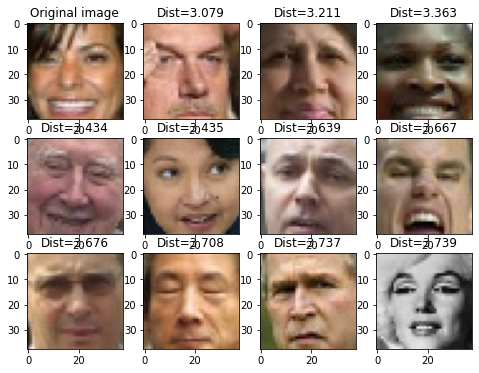

In [37]:
#smiles
show_similar(X_test_tensor[2])

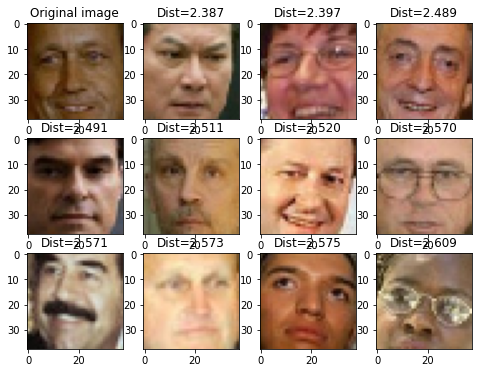

In [38]:
#ethnicity
show_similar(X_test_tensor[500])

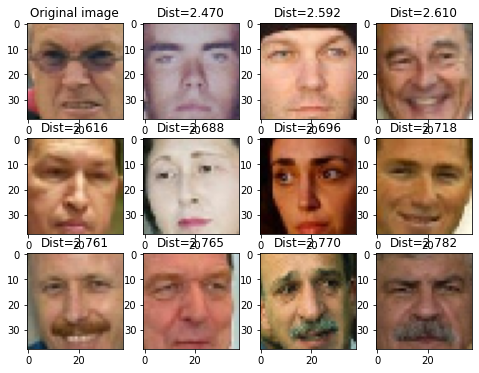

In [39]:
#glasses
show_similar(X_test_tensor[66])

## Bonus: cheap image morphing


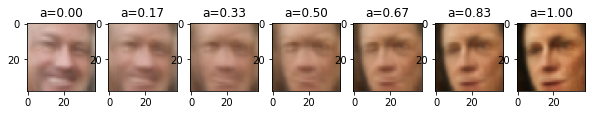

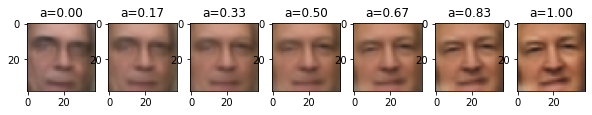

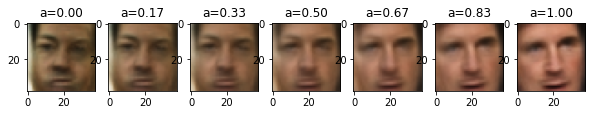

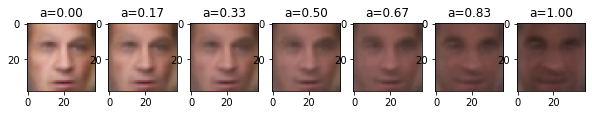

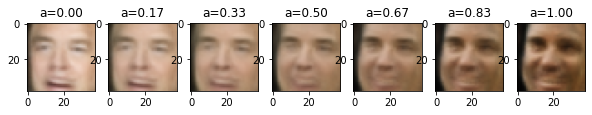

In [43]:

for _ in range(5):
    image1,image2 = X_test_tensor[np.random.randint(0,len(X_test),size=2)]

    image_pair = torch.cat((image1,image2), 0).cuda(device)
    # ^-- note: depending on your implementation, you may need to call torch.permute here
    
    
    code1, code2 = aenc_deep.enc(image_pair)

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = aenc_deep.dec(output_code[None])[0]
        plt.subplot(1,7,i+1)
        plt.imshow(output_image.permute(1, 2, 0).cpu().detach().numpy())
        plt.title("a=%.2f"%a)
        
    plt.show()

Of course there's a lot more you can do with autoencoders.
If you want to generate images from scratch, however, you're better off using generative adversarial networks.